**TP n°3** :  Caractérisation d'une loi de probabilité sur un espace d'images.

#Plan

##Partie I:

Régression quantile par descente de gradient.
* Fonction de coût adaptée
* Régression quantile: un premier exemple
* Régression quantile simultanée


##Partie II:

Echantillonnage par une méthode générative: l'exemple des GAN.
* Principe de base et premier entraînement
* Limites
* Quelques solutions
* Un GAN conditionnel


Durée : 3 h

### Introduction à la partie I:

A travers le premier exercice, on rappelle quelques notions essentielles: loi jointe, lois marginales, loi conditionnelle.

**Exercice 1 (rappel)** : notions de densité, lois marginale, loi jointe, loi conditionnelle, couplage.

Soit $X = (X_1, X_2)$ un [vecteur gaussien](https://) de loi $\mathcal{N}(0, \Gamma)$ avec $\Gamma = \begin{pmatrix} 1 & \epsilon \\ \epsilon & 1 \end{pmatrix}$ et $\epsilon \in [0,1[$

**a.** Quelle est la densité de $X$ ?

$$f(x_1,x_2) = \dfrac{1}{ 2 \pi \sqrt{ 1 - \epsilon^2 }} e^{\text{-} \tfrac{1}{2}  \begin{pmatrix} x_1 & x_2 \end{pmatrix} \: \Gamma^{-1} \begin{pmatrix} x_1 \\ x_2 \end{pmatrix}} $$

avec $$\Gamma^{-1} =  \dfrac{1}{1 - \epsilon^2} \begin{pmatrix} 1 & \text{-} \epsilon \\ \text{-} \epsilon & 1 \end{pmatrix}$$
**b.** Quelles sont les lois marginales de $X$ ?


Pour une loi définie sur un espace à $2$ dimensions par une densité $f(x_1, x_2)$ la loi marginale associée à la coordonnée $x_2$ est définie par la densité:
$$f_2(\boldsymbol{x}) = \int_{x_1} f(x_{1}, \boldsymbol{x}) \; dx_1 $$

Dans le cas d'un vecteur gaussien, les lois marginales sont entièrement caractérisées par l'espérance et les $\Gamma_{j,j}$ de la matrice de covariance. Dans notre cas, les marginales sont des lois normales centrées réduites.

**c.** Calculer la loi conditionnelle de $X_1$ sachant $X_2 = x_2$. Vers quel couplage tend-on lorsque $\epsilon \to 1$ ?

La densité conditionnelle est donnée par:

$$\dfrac{f(x_1, x_2)}{f_2(x_2)}$$

Ici:
 $$f(x_1,x_2) \; \alpha \; \dfrac{exp(\text{-} \tfrac{1}{2}  \begin{pmatrix} x_1 & x_2 \end{pmatrix} \: \Gamma^{-1} \begin{pmatrix} x_1 \\ x_2 \end{pmatrix})}{exp(\text{-} \tfrac{1}{2} x_2^2)}  $$

Ce qui donne après simplification:


$$ f(x_1,x_2) \; \alpha \; exp(\text{-} \tfrac{1}{2 (1 - \epsilon^2)} (x_1 - \epsilon x_2)^2 ) $$

**Note**: ce calcul peut être réalisé par un [calcul matriciel](http://www.normalesup.org/~rpeyre/pro/ensgt/13/mc/condgauss.pdf).

On reconnaît une loi normal d'espérance $\epsilon x_2$, de variance $1 - \epsilon^2$.
Pour $\epsilon \rightarrow 1$ la loi conditionnelle converge vers la masse de Dirac $\delta_{x_2}$.\
La loi conjointe, elle, converge vers le couplage défini par $X_2 \sim \mathcal{N}(0,1) $ et $X_1 = X_2$, c'est à dire une loi gaussienne dégénérée ($det(\Gamma) = 0$) dont le dont le support est réduit à la diagonale d'équation $x_2 = x_1$.





**Note**: un couplage de deux lois $\mathcal{P}$, $\mathcal{Q}$ est un couple de variables aléatoires (X,Y) tel que $X \sim \mathcal{P}$ et $Y \sim \mathcal{Q}$.

### Partie I: régression quantile   

Dans cette partie, on se situe de nouveau dans le cas où les entrées $X$ et les cibles $Y$ de l'apprentissage sont des images de mêmes tailles.
Par contre, on suppose que la dépendance de $Y$ à $X$ est de nature probabiliste. En d'autres termes, il existe des lois conditionnelles $\mathcal{L}_{\{Y | X = x \}}$, et ce sont ces lois **qu'il faudrait pouvoir caractériser**. \\

Ici, nous nous limitons aux marginales conditionnelles, c'est à dire aux lois $\mathcal{L}_{\{Y_{i,j} | X = x \}}$ où $Y_{i,j}$ représente la valeur de la cible $Y$ au pixel $(i,j)$. \\
Pour caractériser ces lois, plusieurs approches sont envisageables. On peut par exemple chercher à en estimer les quantiles ou les moments. Les exercices suivants illustrent une méthode d'estimation des quantiles.


**Exercice 2**: une fonction de coût adaptée

Nous avons déjà vu au TP précédent que l'utilisation de la MAE conduisait le modèle à fournir la médiane conditionnelle, qui est un quantile particulier.
Pour estimer les autres quantiles, il suffit de modifier la MAE.

C'est ce que nous allons faire sur un problème simple où le lien entre l'entrée et la cible est défini par:  
$$Y_{i,j} \sim \mathcal{N}({x}_{i,j}^2, 0.2 \times x_{i,j}) $$

La fonction *gen_proba* du module *utile.py* va nous permettre de "parcourir" notre jeu de données, ou en d'autres termes d'échantillonner le couple $(X,Y)$.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import time

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
os.chdir('drive/MyDrive/TP_2022_corr')

In [ ]:
os.listdir()
from utile import *

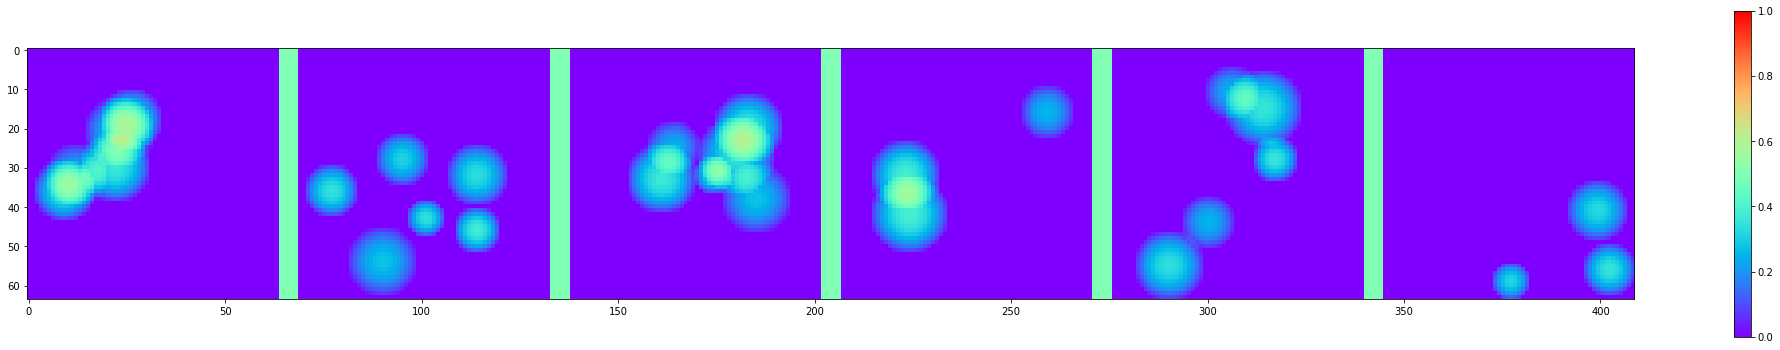

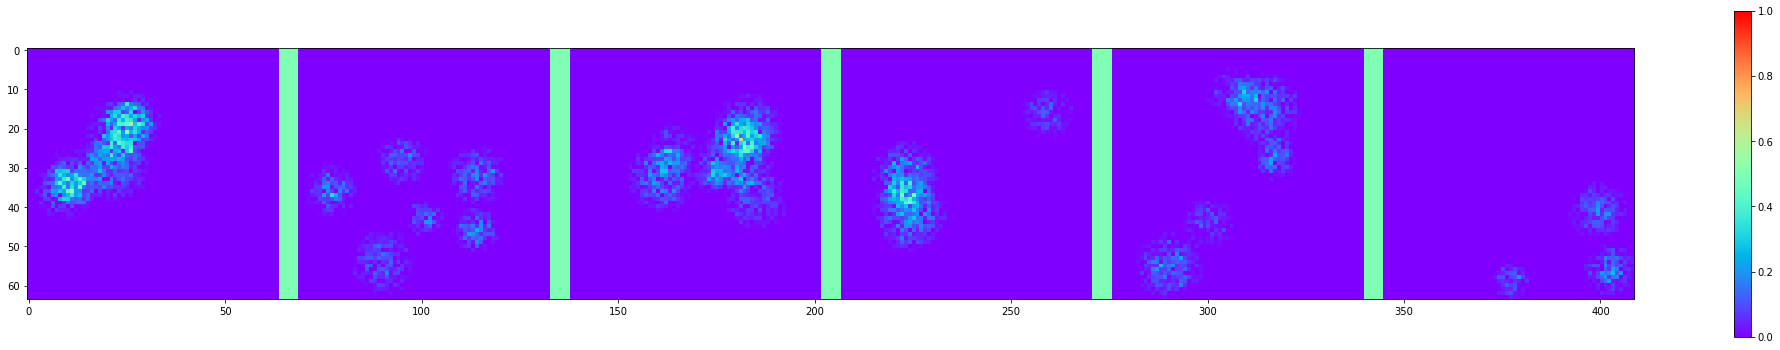

In [ ]:
#Echantillonnage du couple (X,Y) :

input, target = gen_proba(6)
#Entrées
fig0 = plt.figure(0, figsize=(36, 6))
voir_batch2D(input, 6, fig0, k=0, min_scale=0,max_scale=1)

#Cibles
fig1 = plt.figure(1, figsize=(36, 6))
voir_batch2D(target, 6, fig1, k=0, min_scale=0,max_scale=1)

**Q1** Montrer que la fonction de coût définie par:
$$\mathcal{L}(Y,f_\theta(x)) = \rho_t(Y - f_\theta(x))$$
où:
$$\rho_t(u) = t \times max(u,0) + (t-1) \times min(u,0) $$


est d'espérance minimale lorsque $f_\theta(x)$ vaut le quantile d'ordre $t$ associé à $p(Y|X=x)$.



**Réponse** La démonstration repose sur la dérivation des intégrales paramétriques généralisées. Sans s'attarder sur les détails techniques, on peut écrire:
\begin{equation*}
 \partial_q [ \int_{\mathbb{R}} \mathcal{L}(y,q) p(y|x) dy] = \\
   t \ \partial_q [  \int_{q}^{+\infty}  (y - q) p(y|x) dy ] + (t-1) \  \partial_q [\int_{-\infty}^q  (y - q)  p(y|x) dy] \\
=   t - \int_{-\infty}^q p(y|x) dy  
\end{equation*}

Cette quantité s'annulant clairement pour $q$ tel que $\mathbb{P}(Y<q) = t$.




**Q2** En quoi $\rho_t$ généralise-t-elle la MAE ? \\
Dans la cellule suivante, coder $\rho_t$ avec la méthode [.clamp()](https://pytorch.org/docs/stable/generated/torch.clamp.html). Entraîner un U-Net à estimer le neuvième décile (Commencer les premiers exercices de la partie II en attendant la fin de l'entraînement).

In [ ]:
####nouvelle fonction rho:

def rhot(u,t):
        #généralise la valeur absolue (cas t =0.5)
        loss = t*u.clamp(min=0.) + (t-1)*u.clamp(max=0.)
        loss = loss.mean()
        return loss

def criterion(output, target):
  return rhot(target-output,0.1)  #on vise le premier décile

In [ ]:
fcn = UNet(1,1,16).cuda()  #1 canal entrée, 1 canal de sortie, paramètre taille du réseau: 16
import torch.optim as optim
optimizer = optim.Adam(fcn.parameters(), 10**(-3))

In [ ]:
nepochs = 50
nbatches = 100
batchsize = 64

train_losses = []

for epoch in range(nepochs):

    print("Epoch " + str(epoch))
    epoch_losses  = []
    for i in range(nbatches):    # nbatch = datasetsize/batchsize

        #Echantillonnage de (X,Y)
        input,target = gen_proba(batchsize)

        input = input.cuda()
        target = target.cuda()

        # Estimation (passe avant)
        optimizer.zero_grad()
        output = fcn(input)

        # Fonction de coût
        loss = criterion(output,target)

        # Gradients
        loss.backward()

        # MAJ des poids
        optimizer.step()

        epoch_losses.append(loss.detach().cpu())

        del target, input, loss
        torch.cuda.empty_cache()

    epoch_loss = np.mean(epoch_losses)
    train_losses.append(epoch_loss)
    print('epoch loss : \n')
    print(epoch_loss)

Epoch 0
epoch loss : 

0.0012510233
Epoch 1
epoch loss : 

0.0011985454
Epoch 2
epoch loss : 

0.001202923
Epoch 3
epoch loss : 

0.00119212
Epoch 4
epoch loss : 

0.0011871037
Epoch 5
epoch loss : 

0.0011891146
Epoch 6
epoch loss : 

0.0011719073
Epoch 7
epoch loss : 

0.0011589332
Epoch 8
epoch loss : 

0.0011786158
Epoch 9
epoch loss : 

0.0011816272
Epoch 10
epoch loss : 

0.0011747063
Epoch 11
epoch loss : 

0.0011739577
Epoch 12
epoch loss : 

0.0011613105
Epoch 13
epoch loss : 

0.0011722668
Epoch 14
epoch loss : 

0.001151494
Epoch 15
epoch loss : 

0.0011641312
Epoch 16
epoch loss : 

0.0011573369
Epoch 17
epoch loss : 

0.001175082
Epoch 18
epoch loss : 

0.0011774864
Epoch 19
epoch loss : 

0.0011738339
Epoch 20
epoch loss : 

0.001165072
Epoch 21
epoch loss : 

0.0011635852
Epoch 22
epoch loss : 

0.0011971691
Epoch 23
epoch loss : 

0.001181177
Epoch 24
epoch loss : 

0.0011638561
Epoch 25
epoch loss : 

0.0011522289
Epoch 26
epoch loss : 

0.0011680614
Epoch 27
epoch los

**Q3** Visualiser le résultat. Utiliser [torch.distributions.normal.Normal](https://pytorch.org/docs/stable/distributions.html) pour vérifier la convergence.

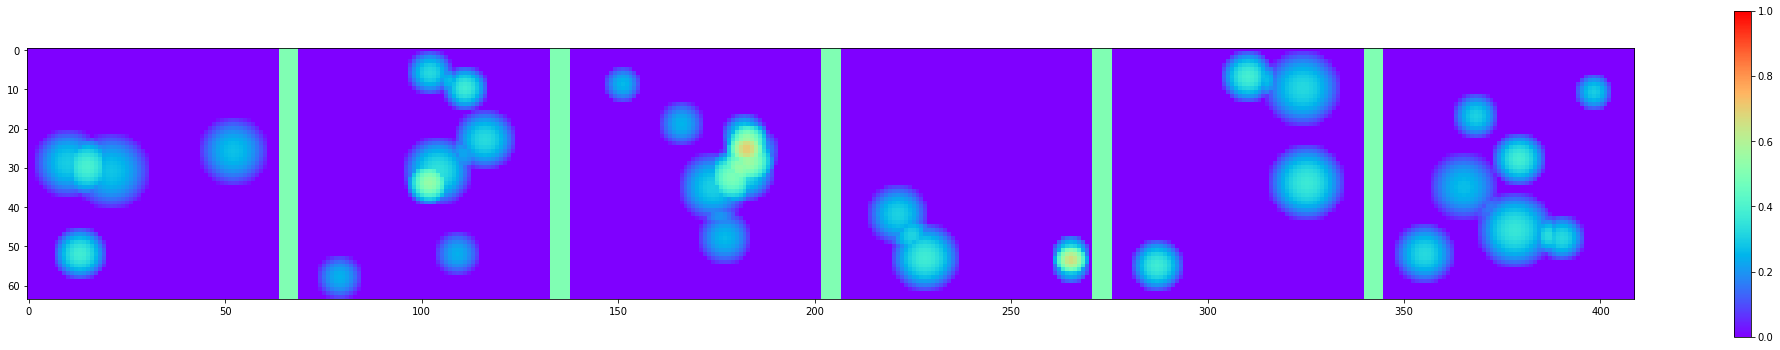

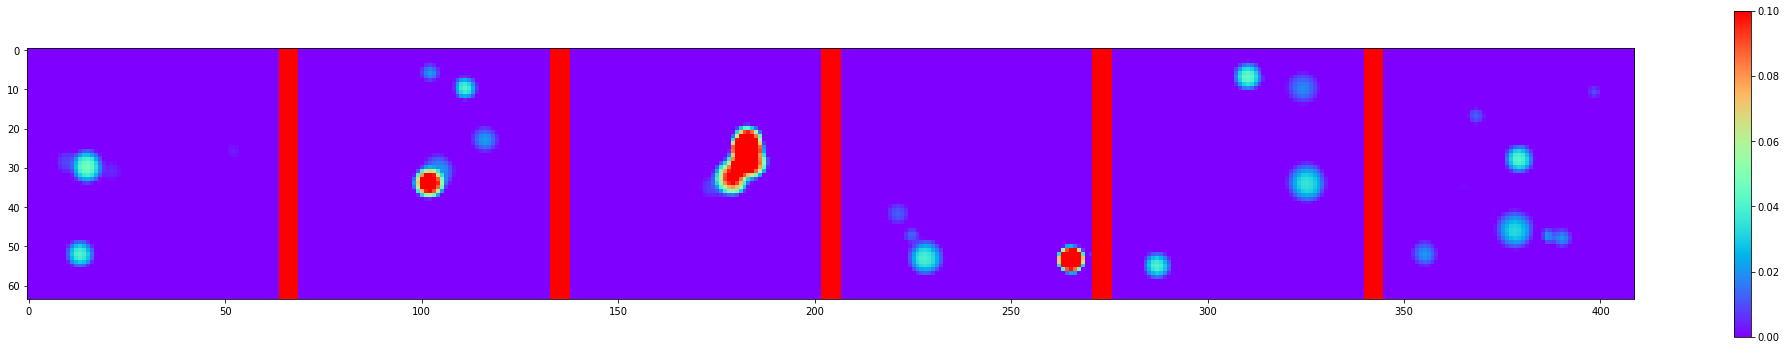

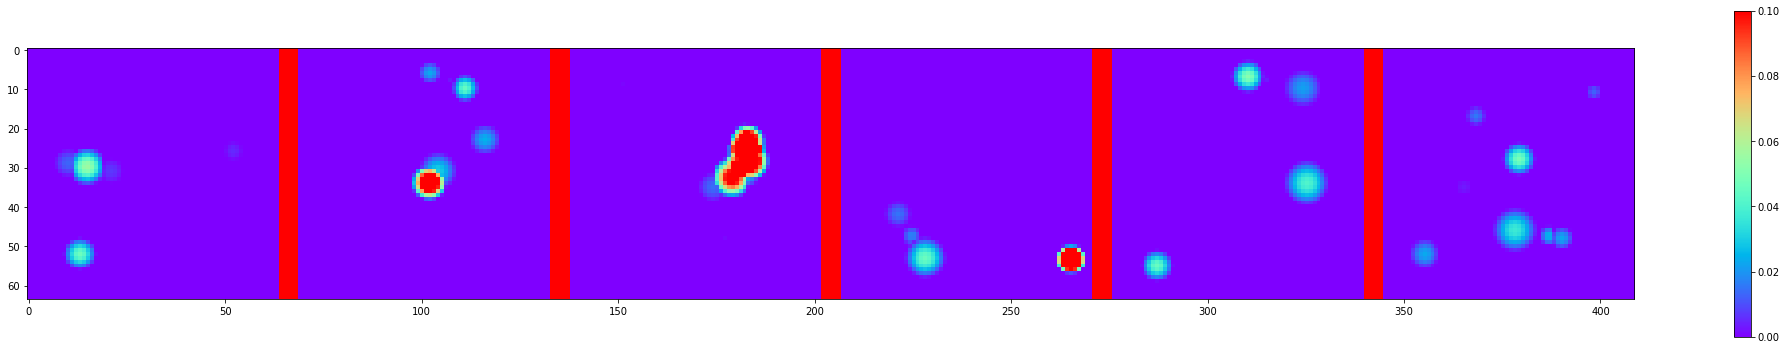

/content/drive/MyDrive/TP_2022_corr/utile.py:20: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(1,1,1)


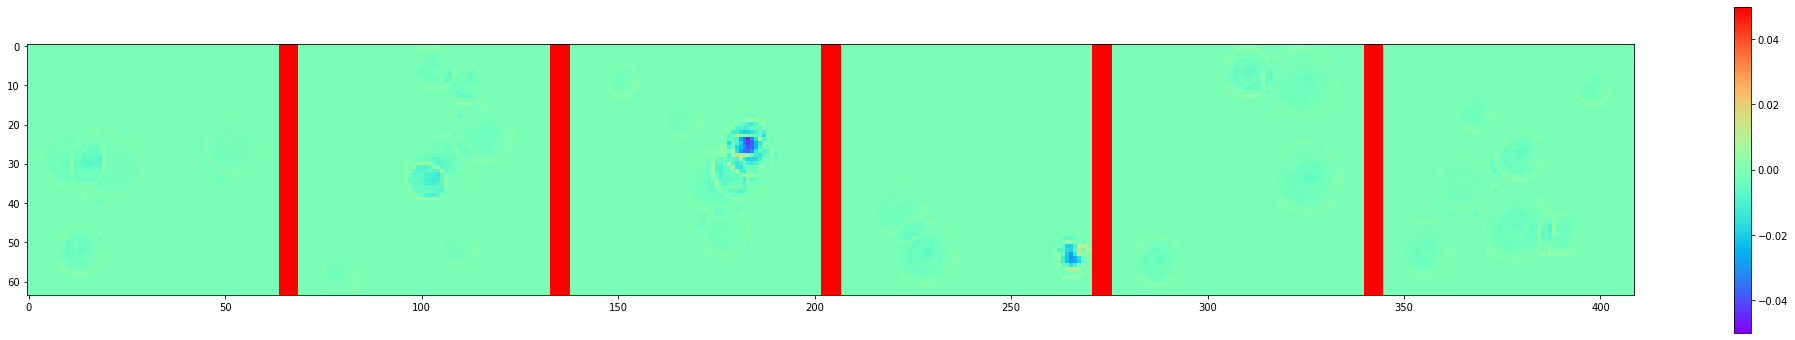

In [ ]:
#visualisation:

fcn.eval()

input, target = gen_proba(6)

output = fcn(input.cuda())



fig = plt.figure(0, figsize=(36, 6))
voir_batch2D(input, 6, fig, k=0, min_scale=0,max_scale=1) #Entrées: première ligne
fig1 = plt.figure(1, figsize=(36, 6))
voir_batch2D(output.detach().cpu(), 6, fig1, k=0, min_scale=0,max_scale=0.1) #Sorties: deuxième ligne

m = torch.distributions.normal.Normal(input**2, 0.2*input+0.000001, validate_args=None)
quantiles = m.icdf(0*input + 0.1)
fig2 = plt.figure(2, figsize=(36, 6))
voir_batch2D(quantiles, 6, fig2, k=0, min_scale=0.,max_scale=0.1) #Premier décile (ground truth)
fig3 = plt.figure(3, figsize=(36, 6))
voir_batch2D(output.detach().cpu() - quantiles, 6, fig2, k=0, min_scale=-0.05,max_scale=0.05) #sorties - ground truth




**Exercice 3**  

On peut chercher à estimer $n$ quantiles à la fois. Pour cela, le plus simple est de:
* changer le nombre de canaux en sortie du U-Net -par exemple 99 canaux s'il s'agit d'estimer les $n = 100$ quantiles d'ordres 1%, 2%, ... 99%.
* définir la fonction de coût globale en sommant les fonctions de coûts individuelles pour chacun des canaux.

Le but de cet exercice est coder une version matricielle de cette fonction de coût globale et d'illustrer la convergence de l'apprentissage.

**Q1** Soit $t$ un vecteur de taille $N-1$ et $M$ un tenseur d'ordre 4. Coder la fonction $dot(t, M) = M^{\prime}$ où $M^{\prime}_{b,i,j} =  \underset{0<c<n}{\sum} t_c  \times M_{b,c,i,j}$. \\
Cette fonction permettra d'appliquer $\rho_{t_c}$ à chaque canal $c$ de la sortie $M$ ($b$ représente l'indice du batch et $i,j$ les dimensions spatiales).

In [ ]:
def dot(t ,  M):
	return (M * t.view((1,t.shape[0],1,1)) ).sum(dim=1)

**Q2** Compléter la classe *QuantileLoss*:

In [ ]:
class QuantileLoss(torch.nn.Module):
    #output doit être de taille: batch_size * (n-1) * nx * ny
    #P(|y-y*|>r) = t%
    def __init__(self , n):
        super(QuantileLoss, self).__init__()
        self.n = n   # discretisation de la CDF n= 100 -> centiles
        self.t = torch.arange(1/n,1,1/n).cuda()  #premier: 1st centile, dernier: 99 centile

    def forward(self, output, target):
        bs, _, nx, ny = target.shape
        d = target.view(bs, 1, nx, ny) - output

    #calcul des losses de la régression quantile
        loss_by_pix = dot( self.t , d.clamp(min =0)  ) + dot( self.t - 1 , d.clamp(max =0))
        loss = torch.mean(loss_by_pix)

        return loss

**Q3** Lancer l'entraînement pour $n=100$ puis évaluer l'estimation.

In [ ]:
n = 100
fcn = UNet(1,n-1,32).cuda()  #1 canal entrée, n-1 canal de sortie, paramètre taille du réseau: 16
import torch.optim as optim
optimizer = optim.Adam(fcn.parameters(), 10**(-3))

criterion = QuantileLoss(n)



In [ ]:
nepochs = 40
nbatches = 100
batchsize = 64

train_losses = []

for epoch in range(nepochs):
    print("Epoch " + str(epoch))
    epoch_losses  = []
    for i in range(nbatches):    # nbatch = datasetsize/batchsize
        #Load inputs


        input,target = gen(batchsize)

        input = input.cuda()
        target = target.cuda()


        optimizer.zero_grad()
        output = fcn(input)

        loss = criterion(output,target)
        loss.backward()

        optimizer.step()


        epoch_losses.append(loss.detach().cpu())

        del target, input, loss
        torch.cuda.empty_cache()

    epoch_loss = np.mean(epoch_losses)
    train_losses.append(epoch_loss)
    print('epoch loss : \n')
    print(epoch_loss)



Epoch 0
epoch loss : 

0.25705585
Epoch 1
epoch loss : 

0.23656675
Epoch 2
epoch loss : 

0.24364215
Epoch 3
epoch loss : 

0.24131025
Epoch 4
epoch loss : 

0.23752041
Epoch 5
epoch loss : 

0.23442705
Epoch 6
epoch loss : 

0.23404953
Epoch 7
epoch loss : 

0.24030985
Epoch 8
epoch loss : 

0.23313794
Epoch 9
epoch loss : 

0.23135445
Epoch 10
epoch loss : 

0.2307611
Epoch 11
epoch loss : 

0.23157929
Epoch 12
epoch loss : 

0.22984016
Epoch 13
epoch loss : 

0.23196198
Epoch 14
epoch loss : 

0.23246315
Epoch 15
epoch loss : 

0.2313808
Epoch 16
epoch loss : 

0.23184668
Epoch 17
epoch loss : 

0.23032068
Epoch 18
epoch loss : 

0.2298012
Epoch 19
epoch loss : 

0.23709115


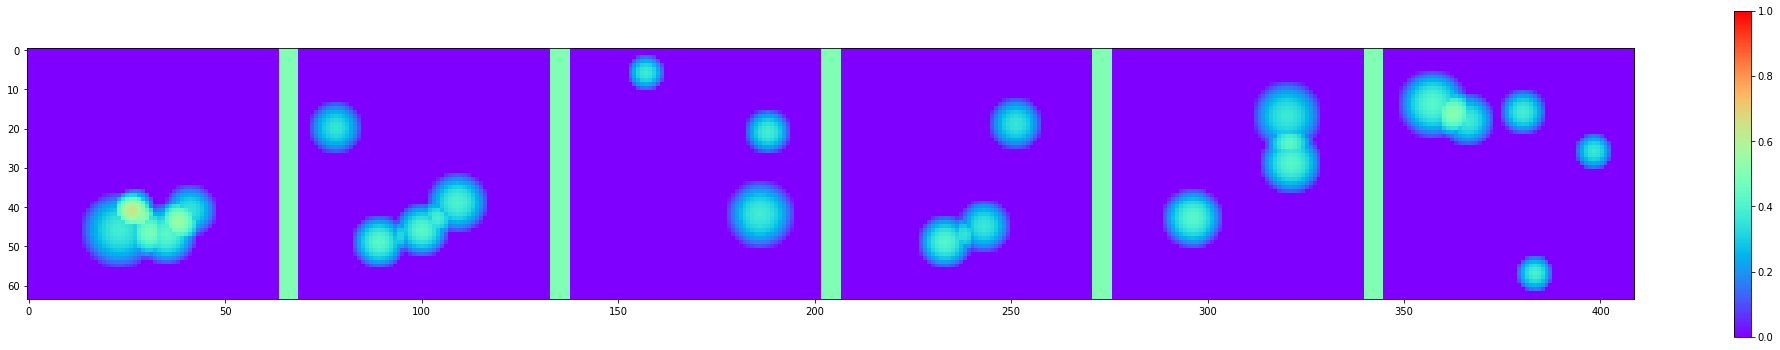

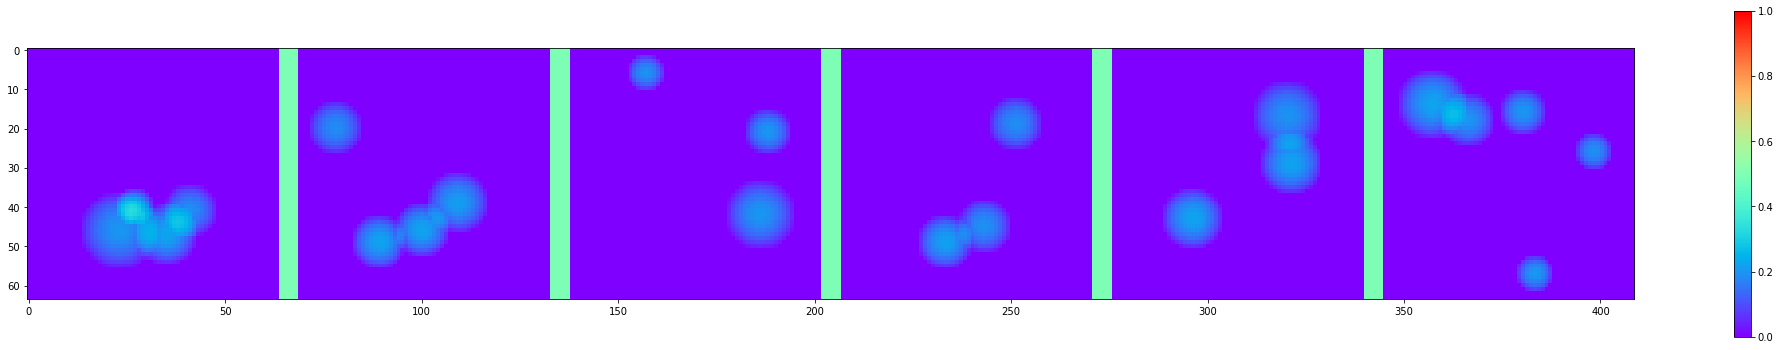

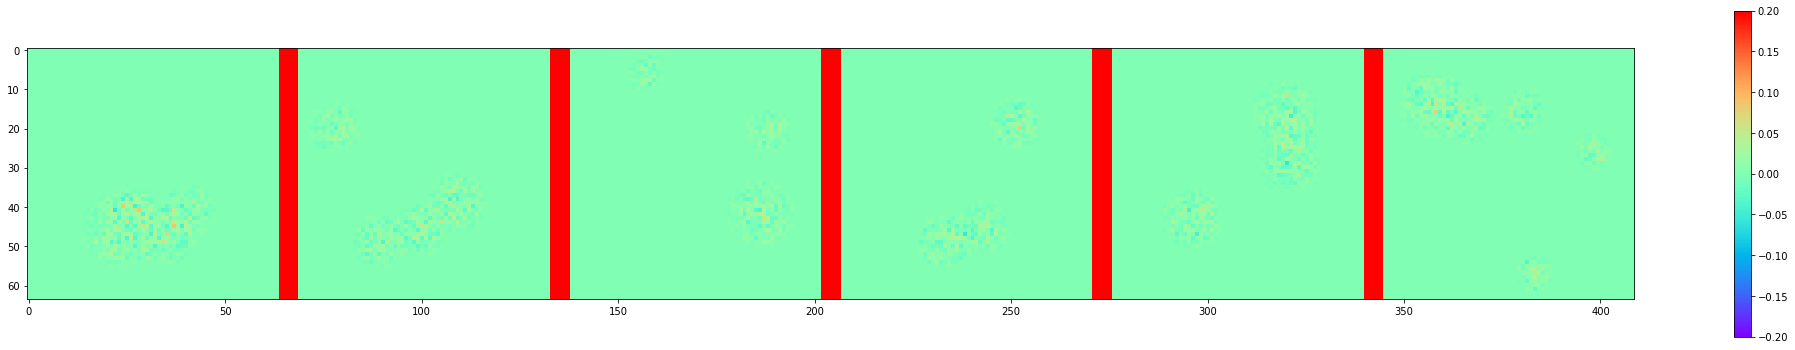

In [ ]:
#visualisation:

fcn.eval()

input, target = gen(6)

output = fcn(input.cuda())

fig = plt.figure(0, figsize=(36, 6))
voir_batch2D(input, 6, fig, k=0, min_scale=0,max_scale=1)
fig1 = plt.figure(1, figsize=(36, 6))
voir_batch2D(output.detach().cpu(), 6, fig1, k=0, min_scale=0,max_scale=1)

m = torch.distributions.normal.Normal(input, 0.2*target+0.001, validate_args=None)
quantiles = m.icdf(0*input + 0.9)
fig2 = plt.figure(2, figsize=(36, 6))  #troisième ligne: différence entre 90 centile et sortie
voir_batch2D(output.detach().cpu()[:,[90],:,:] - quantiles, 6, fig2, k=0, min_scale=-0.2,max_scale=0.2)


tensor(0.3088)


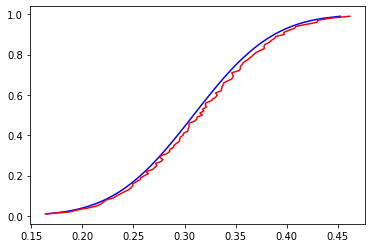

In [ ]:
#tracé de la CDF estimée sur la première image, au pixel de coordonnées (50,25)
pixel = (0,0,50,25)
val = input[pixel]
print(val)
m = torch.distributions.normal.Normal(val, 0.2*val)
x = torch.arange(0.01,1.,0.01)

plt.plot(m.icdf(x), x, color = 'blue')


icdf = output[pixel[0],:,pixel[2],pixel[3]].detach().cpu()

plt.plot(icdf, x, color = 'red')